In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
BCS = 0.0
N_GRID_POINTS = 64
NU_BURGER = 0.01/np.pi # [m^2/s]
STEPS = 100
SHOT_LIST =  [3000]
BATCH_SIZE = 1
REPETITIONS = 3

U_MAX = 1.0  # maximum velocity for Burgers equation (starting condition)

L_left = -1.0
L_right = 1.0
assert L_right > L_left, "L_right must be greater than L_left"

USE_FAKE_HARDWARE = True
NOISE = False

import qiskit, qiskit_aer
from qiskit.circuit import Instruction
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeBrisbane


print("Qiskit / Aer:", qiskit.__version__, qiskit_aer.__version__)

#
# Quantum Simulator
#
backend_ref = FakeBrisbane()
noise_model = NoiseModel.from_backend(backend_ref)

Qiskit / Aer: 2.2.1 0.17.2


In [7]:
def provide_simulator(noise=False):
    if USE_FAKE_HARDWARE == False:
        return AerSimulator()
    else:
        sim = AerSimulator.from_backend(backend_ref)
        sim.set_options(noise_model=None)
        if noise:
            sim.set_options(noise_model=noise_model)
    return sim

def angle_from_prob(p: float) -> float:
    """Return θ = 2*arcsin(sqrt(p)) with clipping to [0,1]."""
    p = float(np.clip(p, 0.0, 1.0))
    return 2.0 * np.arcsin(np.sqrt(p))

# ---------------------------
# Burgers' equation helpers
# ---------------------------

def burgers_convex_weights(u_i, dt, dx, nu):
    """
    Node-local convex weights for 1D viscous Burgers
    """
    lam_nu = nu * dt / (dx * dx)
    c = u_i * dt / dx
    cp = max(c, 0.0)
    cm = max(-c, 0.0)

    wL = lam_nu + cp
    wR = lam_nu + cm
    wC = 1.0 - (wL + wR)
    wL = max(0.0, wL)
    wR = max(0.0, wR)
    wC = max(0.0, wC)
    s = wL + wC + wR
    if s > 0:
        wL, wC, wR = wL / s, wC / s, wR / s
    else:
        wL, wC, wR = 0.0, 1.0, 0.0
    return wL, wC, wR

def choose_dt_burgers(u: np.ndarray, dx: float, nu: float, cfl: float = 0.7) -> float:
    """
    Choose a stable dt for Burgers + diffusion using the combined CFL:
        |u_i| * dt/dx + 2*nu*dt/dx^2 <= 1  for all i
        dt_adv <= dx / max|u|
        dt_diff<= (dx^2) / (2*nu)
    """
    umax = float(np.max(np.abs(u)))
    dt_adv = np.inf if umax == 0.0 else dx / umax
    dt_diff = np.inf if nu == 0.0 else (dx * dx) / (2.0 * nu)
    dt = cfl * min(dt_adv, dt_diff)
    return dt

def burgers_eq_one_step_classical(u: np.ndarray, dt: float, dx: float, nu: float) -> np.ndarray:
    """
    Deterministic explicit step using the same convex weights per node.
    Dirichlet ghost cells u[0]=u[N+1]=BCS are enforced as in your diffusion reference.
    """
    N = u.size - 2
    u_new = np.ones_like(u) * BCS
    for i in range(1, N+1):
        wL, wC, wR = burgers_convex_weights(u[i], dt, dx, nu)
        u_new[i] = wL * u[i-1] + wC * u[i] + wR * u[i+1]
    return u_new

# ---------------------------
# Quantum branching micro-kernel
# ---------------------------
def branching_mk_instruction(uL, uC, uR, wL, wC, wR, name="node") -> Instruction:
    # angles
    theta0 = angle_from_prob(wR)
    left_mass = wL + wC
    thetaL = angle_from_prob(wC / left_mass)
    phiL, phiC, phiR = angle_from_prob(uL), angle_from_prob(uC), angle_from_prob(uR)

    # 3 qubits: [s0, s1, ro]
    sub = QuantumCircuit(3, name=name)

    sub.ry(theta0, 0)
    sub.x(0); sub.cry(thetaL, 0, 1); sub.x(0)

    sub.x(0); sub.x(1); sub.mcry(phiL, [0, 1], 2); sub.x(1); sub.x(0)
    sub.x(0); sub.mcry(phiC, [0, 1], 2); sub.x(0)
    sub.cry(phiR, 0, 2)

    return sub.to_instruction()


# ---------------------------
# Quantum branching micro-kernel for Burgers (batched)
# ---------------------------
def encode_signed_to_prob(u_val: float, M: float) -> float:
    """
    maps [-M, M] to [0, 1]
    """
    if M <= 0:
        return 0.5
    return float(np.clip(0.5 + 0.5 * (u_val / M), 0.0, 1.0))

def decode_prob_to_signed(p: float, M: float) -> float:
    return M * (2.0 * float(np.clip(p, 0.0, 1.0)) - 1.0)

def build_batch_burgers(u: np.ndarray, dt: float, dx: float, nu: float,
                        start_idx: int, batch_size: int, M: float,
                        name="batch_burgers"):
    N = u.size - 2
    nodes = list(range(start_idx, min(start_idx + batch_size, N + 1)))
    mm = len(nodes)

    q = QuantumRegister(3 * mm, "q")
    c = ClassicalRegister(mm, "c")
    circ = QuantumCircuit(q, c, name=name)

    for j, i in enumerate(nodes):
        s0 = 3 * j; s1 = s0 + 1; ro = s0 + 2

        # Weights from the ORIGINAL signed u
        wL, wC, wR = burgers_convex_weights(u[i], dt, dx, nu)

        # Encode signed values to probailities
        pL = encode_signed_to_prob(u[i-1], M)
        pC = encode_signed_to_prob(u[i],   M)
        pR = encode_signed_to_prob(u[i+1], M)

        inst = branching_mk_instruction(pL, pC, pR, wL, wC, wR, name=f"burgers_node_{i}")
        circ.append(inst, [q[s0], q[s1], q[ro]])

    ro_qubits = [q[3*j + 2] for j in range(mm)]
    circ.measure(ro_qubits, c[:mm])
    return circ, nodes



def one_step_burgers_eq_batched(u: np.ndarray, dt: float, dx: float, nu: float,
                                shots: int, batch_size: int, sim=None) -> np.ndarray:
    if sim is None:
        sim = provide_simulator()

    n_points = u.size - 2
    u_new = np.ones_like(u) * BCS

    # Global scale for this step
    maxBurgers = max(float(np.max(np.abs(u[1:-1]))), 1e-12)

    batches, idx_groups = [], []
    for start in range(1, n_points + 1, batch_size):
        bc, nodes = build_batch_burgers(u, dt, dx, nu, start, batch_size, maxBurgers,
                                        name=f"batch_burgers_{start}")
        batches.append(bc)
        idx_groups.append(nodes)

    tbatches = transpile(batches, backend=sim, optimization_level=3, seed_transpiler=42)
    result = sim.run(tbatches, shots=shots).result()

    def p1_from_counts(counts, m, j):
        total = 0
        for s, n in counts.items():
            s = s.zfill(m)
            if s[::-1][j] == '1':
                total += n
        return total / shots

    for k, nodes in enumerate(idx_groups):
        counts = result.get_counts(k)
        m = len(nodes)
        for j, i in enumerate(nodes):
            p_est = p1_from_counts(counts, m, j)   # probability in [0,1]
            u_new[i] = decode_prob_to_signed(p_est, maxBurgers)

    return u_new

def get_circuit_info(u: np.ndarray, dt: float, dx: float, nu: float, batch_size: int, sim=None):
    if sim is None:
        sim = provide_simulator()

    n_points = u.size - 2
    # Global scale for this step
    maxBurgers = max(float(np.max(np.abs(u[1:-1]))), 1e-12)

    batches, idx_groups = [], []
    for start in range(1, n_points + 1, batch_size):
        bc, nodes = build_batch_burgers(u, dt, dx, nu, start, batch_size, maxBurgers,
                                        name=f"batch_burgers_{start}")
        batches.append(bc)
        idx_groups.append(nodes)

    tbatches = transpile(batches, backend=sim, optimization_level=3, seed_transpiler=42)
    metrics = []
    for k, qc in enumerate(tbatches):
        # Basic info
        n_qubits  = qc.num_qubits
        n_clbits  = qc.num_clbits
        size      = qc.size()                 # total instructions
        depth     = qc.depth()                # includes measure/barrier
        depth_nom = qc.depth(                 # ignore measure/barrier
            filter_function=lambda inst: inst.operation.name not in ("measure", "barrier")
        )
        ops = qc.count_ops() 
        metrics.append({
            "batch": k,
            "name": qc.name,
            "nodes": list(idx_groups[k]),
            "n_qubits": n_qubits,
            "n_clbits": n_clbits,
            "size": size,
            "depth": depth,
            "depth_no_meas": depth_nom,
            "ops": dict(ops)
        })

    # Print metrics
    for m in metrics:
        print(
            f"{m['name']}: depth={m['depth']} (no-meas {m['depth_no_meas']}), "
            f"size={m['size']}, qubits={m['n_qubits']}, operations={m['ops']}")

In [8]:
def burgers_test(N=63, steps=40, shots_list=(1000, 4000, 8000), repetitions=3, nu=0.01/np.pi,
                 batch_size=BATCH_SIZE, noise=False):
    
    u_noise = None

    sim = provide_simulator(noise=noise)

    # grid on [-1,1] with ghost cells
    x = np.linspace(L_left, L_right, N + 2)
    dx = (L_right - L_left) / (N + 1)
    
    time_array = np.zeros(steps)

    u = np.zeros(N + 2) + BCS
    u[1:-1] = -np.sin(np.pi * x[1:-1]) + BCS
    dt = choose_dt_burgers(u, dx, nu, cfl=0.9)
    get_circuit_info(u, dt, dx, nu, batch_size=BATCH_SIZE, sim=sim)

    print(f"\nBurgers test: N={N}, steps={steps}, ν={nu}, dx={dx:.6g}")

    profiles = {}
    L_inf_tot = []
    L2_tot = []

    all_errors = {}
    all_profiles_time = {}

    for ss in shots_list:
        L2 = []
        L_inf = []

        Linf_vec = []
        L2_vec = []
        
        for r in range(repetitions):
            # Initial condition and boundaries
            u = np.zeros(N + 2) + BCS
            u[1:-1] = - U_MAX * np.sin(np.pi * x[1:-1]) + BCS
            u_ref = u.copy()
            dt = choose_dt_burgers(u_ref, dx, nu, cfl=0.9) # [s]

            # u_analytic_time = np.zeros(N+2) + BCS

            print(f"Burgers: shots={ss}, rep={r+1}/{repetitions}")

            u_time_matrix = np.zeros((steps, N+2))
            u_time_analytic_matrix = np.zeros((steps, N+2))

            for n in range(steps):
                print("Step ", n, "/",steps)
                # Classical explicit update
                u_ref = burgers_eq_one_step_classical(u_ref, dt, dx, nu)
                u_time_analytic_matrix[n,:] = u_ref.copy()
                # quantum
                u = one_step_burgers_eq_batched(u, dt, dx, nu, shots=ss, batch_size=batch_size, sim=sim)
                u_time_matrix[n,:] = u.copy()

                time_array[n] += n*dt / repetitions

            # errors
            diff = u[1:-1] - u_ref[1:-1]
            linf = np.max(np.abs(diff))
            l2 = np.sqrt(np.mean(diff**2))
            L_inf.append(linf)
            L2.append(l2)

            diff_matrix = u_time_matrix - u_time_analytic_matrix
            linf_vec = np.max(np.abs(diff_matrix), axis=1)
            l2_vec = np.sqrt(np.mean(diff_matrix**2, axis=1))
            Linf_vec.append(linf_vec)
            L2_vec.append(l2_vec)

            if r == 0:
                profiles[ss] = (u.copy(), u_ref.copy())
                all_profiles_time[ss] = (u_time_matrix.copy(), u_time_analytic_matrix.copy())


        L_inf_tot.append(L_inf)
        L2_tot.append(L2)

        print(f"{ss:<9d} {np.mean(L_inf):.4f} ± {np.std(L_inf):.4f}  {np.mean(L2):.4f} ± {np.std(L2):.4f}")

        Linf_vec = np.array(Linf_vec)
        L2_vec = np.array(L2_vec)
        mean_L_inf_time = np.mean(Linf_vec, axis=0)
        std_L_inf_time = np.std(Linf_vec, axis=0)
        mean_L2_time = np.mean(L2_vec, axis=0)
        std_L2_time = np.std(L2_vec, axis=0)

        all_errors[ss] = {
            'mean_L_inf_time': mean_L_inf_time,
            'std_L_inf_time': std_L_inf_time,
            'mean_L2_time': mean_L2_time,
            'std_L2_time': std_L2_time
        }

    return {
        'x': x,
        'u_analytic': u_ref,
        'profiles_for_plot': profiles,
        'all_profiles_time': all_profiles_time,
        'all_errors': all_errors,
        'time': time_array,
        'shots_list': shots_list,
        'steps': steps,
        'u_noise': u_noise
    }

convergence_results = burgers_test(N=N_GRID_POINTS, steps=STEPS,
                 shots_list=SHOT_LIST, repetitions=REPETITIONS,
                 nu=NU_BURGER, batch_size=BATCH_SIZE, noise=NOISE)


batch_burgers_1: depth=168 (no-meas 167), size=252, qubits=127, operations={'rz': 130, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_2: depth=167 (no-meas 166), size=249, qubits=127, operations={'rz': 127, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_3: depth=168 (no-meas 167), size=250, qubits=127, operations={'rz': 128, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_4: depth=167 (no-meas 166), size=249, qubits=127, operations={'rz': 127, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_5: depth=168 (no-meas 167), size=252, qubits=127, operations={'rz': 130, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_6: depth=166 (no-meas 165), size=251, qubits=127, operations={'rz': 129, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_7: depth=168 (no-meas 167), size=249, qubits=127, operations={'rz': 127, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_burgers_8: depth=168 (no-meas 167), size=249, qubits=127, operations={'rz': 1

In [9]:
# system Tau for Burgers
tau_adv = (L_right - L_left) / U_MAX  # setting max|u|=U_MAX
tau_diff = (L_right - L_left)**2 / NU_BURGER

Re = tau_diff / tau_adv
print(f"System time scales for Burgers equation:")
print(f"  Advective time scale: tau_adv = {tau_adv:.4g} s")
print(f"  Diffusive time scale: tau_diff = {tau_diff:.4g} s")
print(f"  Reynolds number: Re = {Re:.4g}\n")

if Re > 100:
    print("Setting up system time scale based on advection.")
    tau = tau_adv
elif Re < 0.01:
    print("Setting up system time scale based on diffusion.")
    tau = tau_diff
else:
    print("Setting up system time scale based on mixed advection-diffusion.")
    tau = (tau_adv * tau_diff) / (tau_adv + tau_diff)

System time scales for Burgers equation:
  Advective time scale: tau_adv = 2 s
  Diffusive time scale: tau_diff = 1257 s
  Reynolds number: Re = 628.3

Setting up system time scale based on advection.


<>:29: SyntaxWarning: invalid escape sequence '\i'
<>:29: SyntaxWarning: invalid escape sequence '\i'
/var/folders/9f/_xx5w7bj79b0pd_wr2l27y000000gn/T/ipykernel_97325/3844385222.py:29: SyntaxWarning: invalid escape sequence '\i'
  plt.plot(time_plot, mean_L_inf_time, label="$L_\infty$", color='blue', linewidth=2)


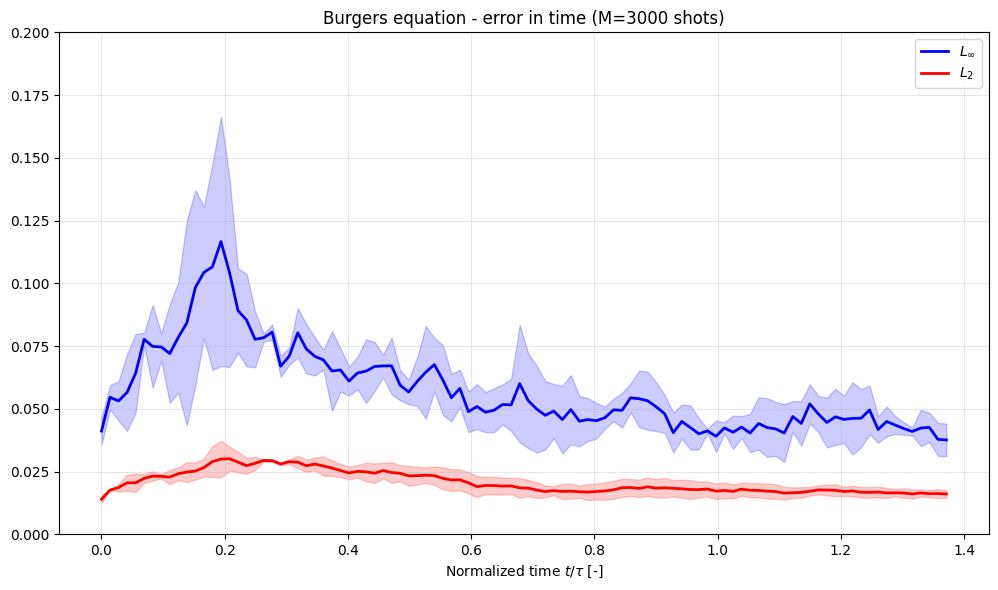

In [26]:
# plot on time_step
# plot on physical normalized time "t/tau"

normalize_time = True
physical_time = False

for ss in convergence_results['shots_list']:
    errors = convergence_results['all_errors'][ss]
    mean_L_inf_time = errors['mean_L_inf_time']
    std_L_inf_time = errors['std_L_inf_time']
    mean_L2_time = errors['mean_L2_time']
    std_L2_time = errors['std_L2_time']
    steps = convergence_results['steps']

    if normalize_time:
        time_array = convergence_results['time']
        time_plot = time_array / tau
        string = "Normalized time $t / \\tau$ [-]"
    elif physical_time:
        time_plot = convergence_results['time']
        string = "Physical time $t$ [s]"
    else:
        time_plot = range(1, steps+1)
        string = "Time steps"

    plt.figure(figsize=(10, 6))
    plt.title(f"Burgers equation - error in time (M={ss} shots)")
    plt.xlabel(f"{string}")
    plt.plot(time_plot, mean_L_inf_time, label="$L_\infty$", color='blue', linewidth=2)
    plt.fill_between(time_plot, mean_L_inf_time - std_L_inf_time, 
                     mean_L_inf_time + std_L_inf_time, alpha=0.2, color='blue')
    plt.plot(time_plot, mean_L2_time, label="$L_2$", color='red', linewidth=2)
    plt.fill_between(time_plot, mean_L2_time - std_L2_time, 
                     mean_L2_time + std_L2_time, alpha=0.2, color='red')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.ylim([0, 0.20])
    plt.show()

<Figure size 1200x700 with 0 Axes>

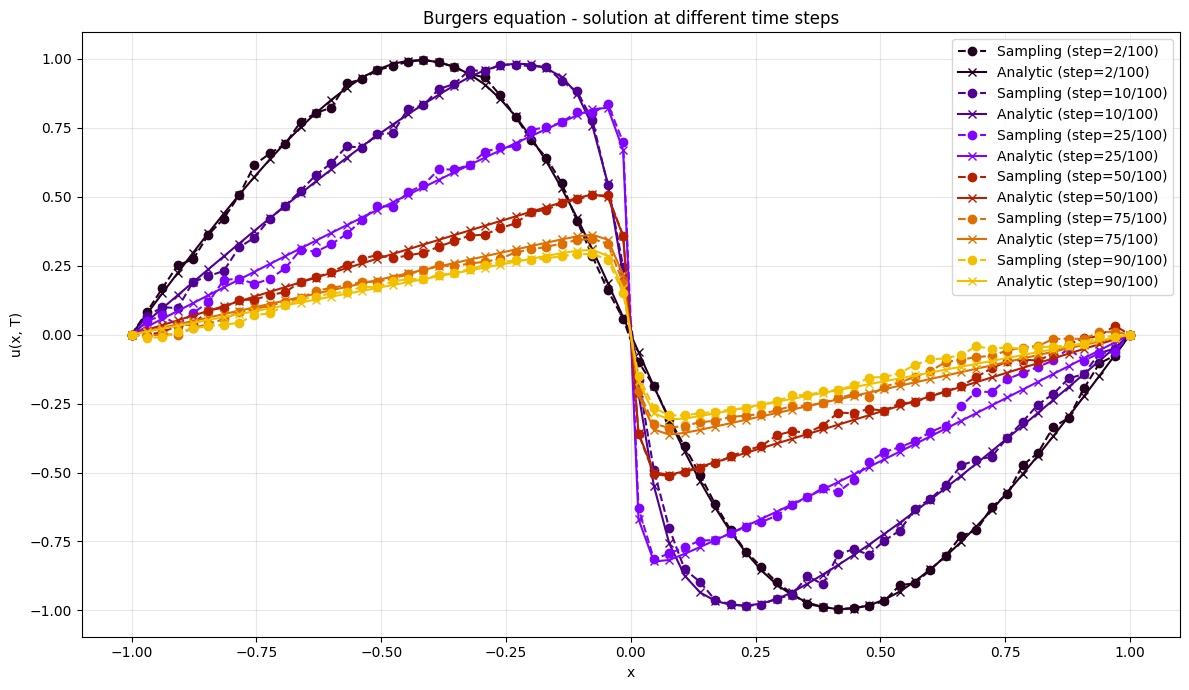

In [ ]:
percentage_list = [2, 10, 25, 50, 75, 90]

x = convergence_results['x']
shots_list = convergence_results['shots_list']

# Use first shot configuration for illustration
for ss in convergence_results['shots_list']:
    # u_time_matrix, u_time_analytic_matrix = convergence_results['all_profiles_time'][ss]

    data = convergence_results['all_profiles_time'].get(ss, None)
    if data is not None:
        u_time_matrix, u_time_analytic_matrix = data
    else:
        print(f"No profile data for shots={ss}, skipping plot.")
        continue
    
    steps = convergence_results['steps']

    colorlist = plt.cm.gnuplot(np.linspace(0, 1, steps))
    plt.figure(figsize=(12, 7))
    plt.figure(figsize=(12, 7))
    for percentage in percentage_list:
        step = int(round((percentage / 100) * steps))
        plt.plot(x[:], u_time_matrix[step, :], color=colorlist[step], linestyle='--', 
                marker="o", label=f"Sampling (step={step}/{steps})")
        plt.plot(x[:], u_time_analytic_matrix[step, :], color=colorlist[step], 
                marker="x", label=f"Classical (step={step}/{steps})")
    plt.xlabel("x")
    plt.ylabel("u(x, T)")
    plt.title(f"Burgers equation - solution at different time steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

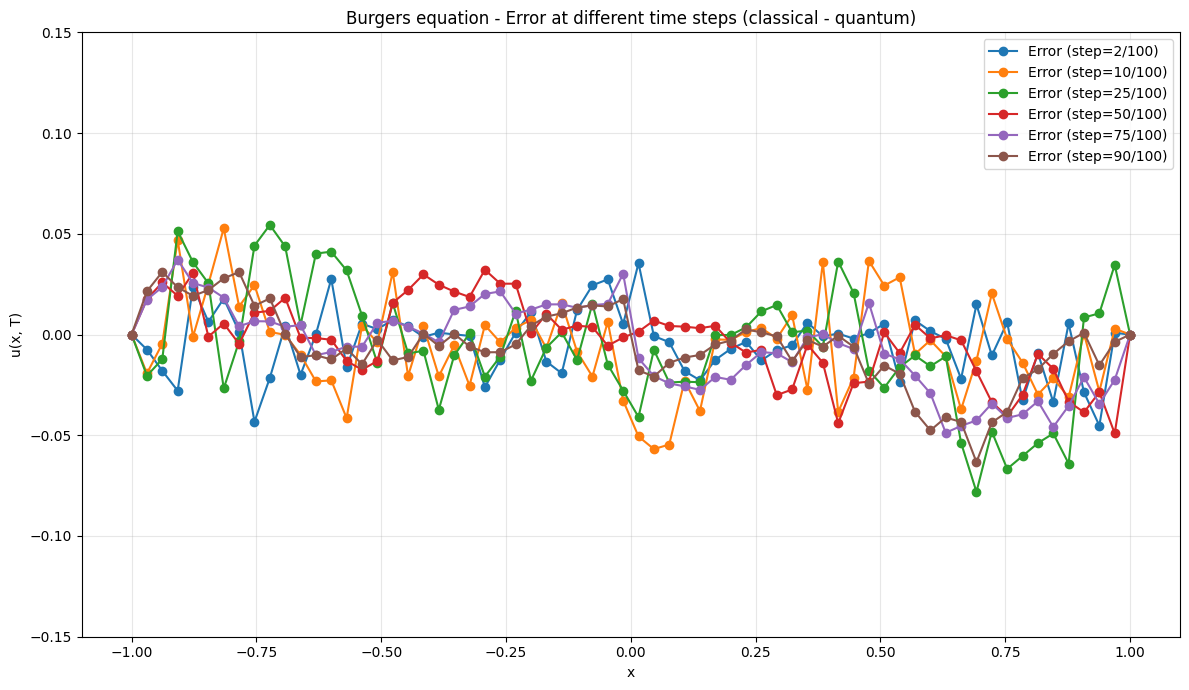

In [12]:
x = convergence_results['x']
shots_list = convergence_results['shots_list']
M = shots_list[0]
u_time_matrix, u_time_analytic_matrix = convergence_results['all_profiles_time'][M]
steps = convergence_results['steps']

# colorlist = plt.cm.gnuplot(np.linspace(0, 1, steps))
plt.figure(figsize=(12, 7))
for percentage in percentage_list:
    step = int(round((percentage / 100) * steps))
    plt.plot(x[:], u_time_analytic_matrix[step, :]- u_time_matrix[step, :], 
             marker="o", label=f"Error (step={step}/{steps})")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.title(f"Burgers equation - Error at different time steps (classical - quantum)")
# plt.plot(x[:], np.sinc((4*x)-2) * 0.3, linestyle='--', color='black', label="Sync reference")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.ylim([-0.15, 0.15])
plt.show()

In [13]:
# plot u_noise
u_noise = convergence_results['u_noise']

if u_noise is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(x[:], u_noise[:], marker='o', linestyle='--', label="u_noise")
    plt.xlabel("x")
    plt.ylabel("u_noise")
    plt.title(f"Noise component after filtering (CUTOFF={CUTOFF})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

- - -
EXTRA
- - -

Solving Burgers' equation using integral (Hopf-Cole) method...
Computing solutions at specified time points...
Computing at 2% (t = 0.055s)...
Computing at 10% (t = 0.274s)...
Computing at 25% (t = 0.686s)...
Computing at 50% (t = 1.371s)...
Computing at 75% (t = 2.057s)...
Computing at 90% (t = 2.468s)...

Shock Development Statistics:
Time		Max Gradient	Min Gradient	Gradient Range	Shock Location
--------------------------------------------------------------------------------
0.000s		3.136		-3.132		6.269		0.016
0.055s		9.357		-3.767		13.124		-0.016
0.274s		2.802		-13.652		16.453		0.016
0.686s		1.275		-27.762		29.037		-0.016
1.371s		0.677		-16.849		17.525		-0.016
2.057s		0.462		-11.291		11.753		0.016
2.468s		0.388		-9.225		9.613		0.016


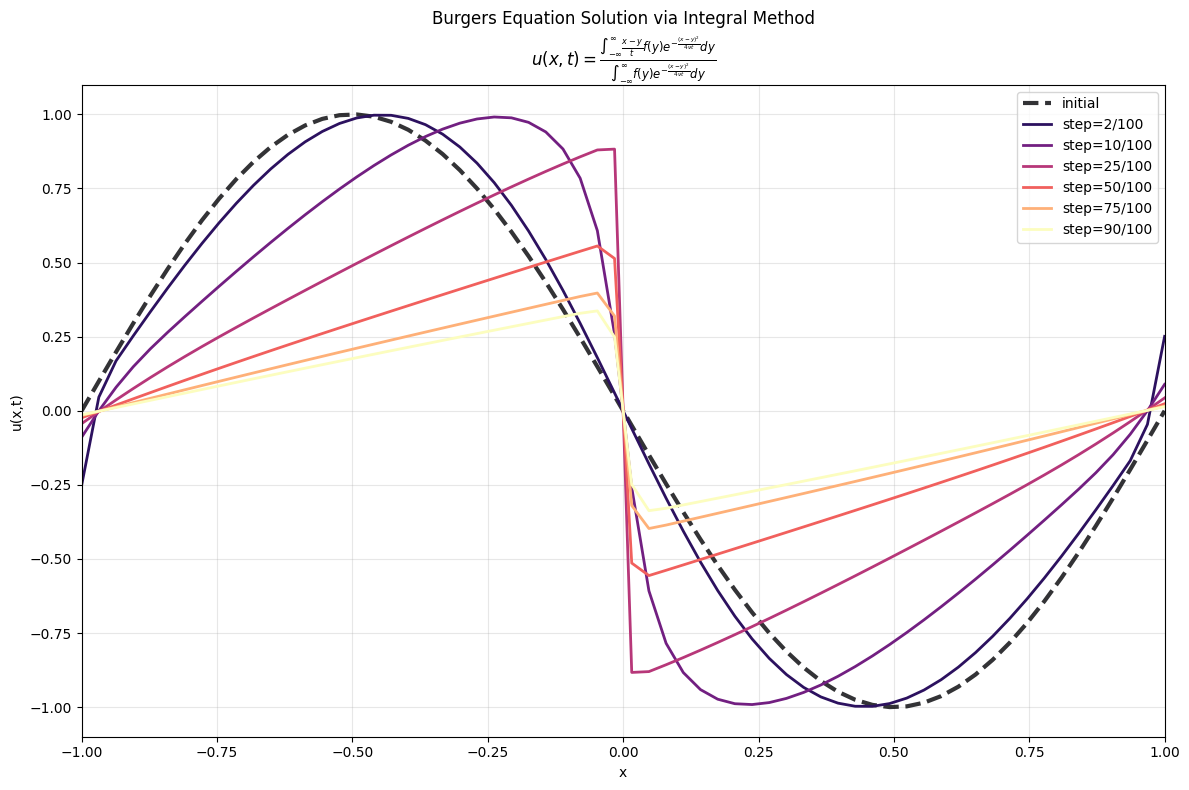

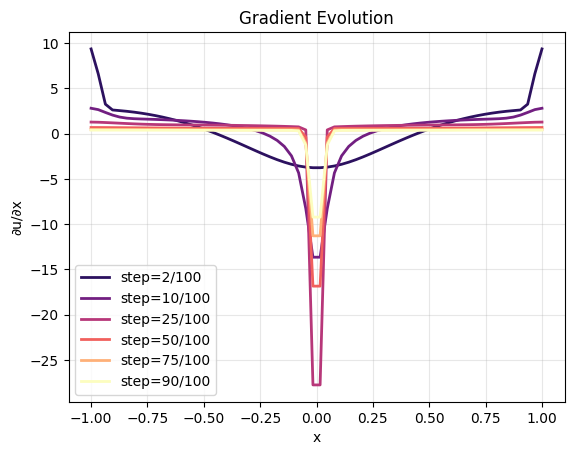

In [24]:
# Burgers' Equation Solution via Hopf-Cole Transformation

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Parameters
N = N_GRID_POINTS  # grid points
nu = NU_BURGER  # viscosity
t_start = 0.0
num_steps = STEPS
dt = (time_array[-1] - time_array[0]) / num_steps

# Spatial domain
x = np.linspace(L_left, L_right, N)

# Initial condition
u0 = -U_MAX*np.sin(np.pi * x)

# Percentages to plot
percentages = percentage_list
time_points = [int(p/100 * num_steps) for p in percentages]

print("Solving Burgers' equation using integral (Hopf-Cole) method...")

def initial_condition(x):
    """Initial condition u0(x) = -sin(πx)"""
    return -U_MAX*np.sin(np.pi * x)

def F(y, x, t, nu):
    """
    Helper function for the integral solution
    F(y) = ∫u0(z)dz from 0 to y
    """
    result = integrate.quad(lambda z: initial_condition(z), 0, y)[0]
    return result

def burgers_integral_solution(x, t, nu):
    """
    Solve Burgers' equation using the Hopf-Cole transformation
    u(x,t) = ∫[(x-y)/t * f(y) * exp(-(x-y)^2/(4*nu*t))] dy / ∫[f(y) * exp(-(x-y)^2/(4*nu*t))] dy
    where f(y) = exp(-1/(2*nu) * ∫u0(z)dz from 0 to y)
    """
    if t == 0:
        return initial_condition(x)
    
    def integrand_num(y):
        F_val = F(y, x, t, nu)
        f_y = np.exp(-1/(2*nu) * F_val)
        gaussian = np.exp(-(x - y)**2 / (4*nu*t))
        return ((x - y) / t) * f_y * gaussian
    
    def integrand_den(y):
        F_val = F(y, x, t, nu)
        f_y = np.exp(-1/(2*nu) * F_val)
        gaussian = np.exp(-(x - y)**2 / (4*nu*t))
        return f_y * gaussian
    
    # Numerical integration over domain
    numerator = integrate.quad(integrand_num, L_left, L_right, limit=100)[0]
    denominator = integrate.quad(integrand_den, L_left, L_right, limit=100)[0]
    
    return numerator / denominator

# Vectorize the solution function
burgers_integral_solution_vec = np.vectorize(burgers_integral_solution, excluded=['t', 'nu'])

# Store solutions and gradients
solutions = {}
gradients = {}
shock_stats = {}

solutions['0%'] = u0
# Compute initial gradient
gradients['0%'] = np.gradient(u0, x)

print("Computing solutions at specified time points...")

for percentage in percentages:
    t_val = percentage/100 * time_array[-1]
    print(f"Computing at {percentage}% (t = {t_val:.3f}s)...")
    
    u_sol = burgers_integral_solution_vec(x, t_val, nu)
    solutions[f'{percentage}%'] = u_sol
    # Compute gradient
    gradients[f'{percentage}%'] = np.gradient(u_sol, x)

# Calculate shock development statistics
print("\nShock Development Statistics:")
print("Time\t\tMax Gradient\tMin Gradient\tGradient Range\tShock Location")
print("-" * 80)

for percentage in [0] + percentages:
    key = f'{percentage}%' if percentage > 0 else '0%'
    t_val = percentage/100 * time_array[-1] if percentage > 0 else 0.0
    
    grad = gradients[key]
    max_grad = np.max(grad)
    min_grad = np.min(grad)
    grad_range = max_grad - min_grad
    
    # Find shock location (where gradient is most negative/steepest)
    shock_idx = np.argmin(grad)
    shock_loc = x[shock_idx]
    
    shock_stats[key] = {
        'time': t_val,
        'max_gradient': max_grad,
        'min_gradient': min_grad,
        'gradient_range': grad_range,
        'shock_location': shock_loc,
        'shock_strength': -min_grad  # Strength is positive magnitude of most negative gradient
    }
    
    print(f"{t_val:.3f}s\t\t{max_grad:.3f}\t\t{min_grad:.3f}\t\t{grad_range:.3f}\t\t{shock_loc:.3f}")

# Plotting - Main solution plot
plt.figure(figsize=(12, 8))

colors = plt.cm.magma(np.linspace(0, 1, len(percentages) + 1))

# Plot initial condition
plt.plot(x, solutions['0%'], color=colors[0], linewidth=3, linestyle='--', 
         label='initial', alpha=0.8)

# Plot solutions at different times
for i, percentage in enumerate(percentages):
    key = f'{percentage}%'
    t_val = percentage/100 * time_array[-1]
    plt.plot(x, solutions[key], color=colors[i+1], linewidth=2, 
             label=f'step={round(percentage / 100 * num_steps)}/{num_steps}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Burgers Equation Solution via Integral Method\n' + 
          r'$u(x,t) = \frac{\int_{-\infty}^{\infty} \frac{x-y}{t} f(y) e^{-\frac{(x-y)^2}{4\nu t}} dy}' +
          r'{\int_{-\infty}^{\infty} f(y) e^{-\frac{(x-y)^2}{4\nu t}} dy}$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(L_left, L_right)
plt.tight_layout()
plt.show()

# Plot 3: Gradient evolution at selected times
plt.figure()
selected_times = ['0%'] + [f'{p}%' for p in percentages if p in [25, 50, 75, 90]]
for i, percentage in enumerate(percentages):
    color_idx = 0 if percentage == 0 else percentages.index(percentage) + 1
    plt.plot(x, gradients[f'{percentage}%'], color=colors[color_idx], linewidth=2, 
             label=f'step={round(percentage / 100 * num_steps)}/{num_steps}')

plt.xlabel('x')
plt.ylabel('∂u/∂x')
plt.title('Gradient Evolution')
plt.grid(True, alpha=0.3)
plt.legend()